In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date, time, timedelta
from dateutil import parser
from dateutil import rrule

from sklearn.metrics import auc, roc_curve, classification_report

#import h2o
#from h2o.frame import H2OFrame
#from h2o.estimators.random_forest import H2ORandomForestEstimator
#from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline
sns.set(style="white",context="talk")

# !pip install reverse_geocoder

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Goal
1. Identify those users that in your dataset never went above the monthly credit card limit (calendar month).(user_id)
2. Implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that.We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.
3. Implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further

# 1. Load the dataset

In [4]:
# cc: general information about the credit card and its holder
cc = pd.read_csv("/content/drive/My Drive/Colab Notebooks/A collection of data challenge/10. Credit Card Transactions/cc_info.csv",sep = ",")
# tx: information about each transaction that happens between Aug,1 and Oct, 30 for the credit cards in cc_info.
tx = pd.read_csv("/content/drive/My Drive/Colab Notebooks/A collection of data challenge/10. Credit Card Transactions/transactions.csv",sep = ",")

#　cc = pd.read_csv("cc_info.csv",sep = ",")
# tx = pd.read_csv("transactions.csv",sep = ",")

In [5]:
def view(df):
    # Exploring the data types, number of unique values and missing values
    cols = df.columns
    print(f"The dataset consists of {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"The columns are: {df.columns.tolist()}")
    return pd.concat([pd.DataFrame({"data_types":df.dtypes, 
              "value_counts": df.nunique(),
             "null_counts": df.isnull().sum()}).T,df.iloc[0:3,:]],axis = 0)

In [6]:
view(cc)

The dataset consists of 984 rows and 5 columns
The columns are: ['credit_card', 'city', 'state', 'zipcode', 'credit_card_limit']


,credit_card,city,state,zipcode,credit_card_limit
data_types,int64,object,object,int64,int64
value_counts,984,124,35,124,28
null_counts,0,0,0,0,0
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000


In [8]:
# rename the date column as time to avoid naming collision
tx.columns=['credit_card',
 'time',
 'transaction_dollar_amount',
 'Long',
 'Lat']

data = pd.merge(left = tx, right = cc, how = "inner", on = "credit_card")
data.head(3)

,credit_card,time,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000


# Question 1
Identify those users that in your dataset never went above the monthly credit card limit (calendar month).(user_id)

In [9]:
def add_date_factors(df, ts_col, is_datetime):
    '''
    Assumption: the currect ts_col is a timestamp datatype
    
    Input:
    df (dataframe, target dataframe to be transformed)
    ts_col(string, name of the timestamp column)
    is_datetime(boolean, whether ts_col is datetime object or not)
    
    Output:
    This function generates hour, hour_of_day, date, weekday, week_of_month, months, year
    '''
    if is_datetime:
        pass
    else:
        df[ts_col] = list(map(lambda x: datetime.fromisoformat(x),df[ts_col].replace(":60",":59", regex=True)))

    # Hour
    df["hour"] = list(map(lambda x: x.hour, df[ts_col]))    

    # Hour of day
    def get_hourday(x):
        if 0<= x < 6:
            return "midnight"
        elif 6<= x < 12:
            return "morning"
        elif 12<= x < 18:
            return "afternoon"
        else:
            return "night"
    df["hourday"] = list(map(lambda x: get_hourday(x), df["hour"]))
        
    # Date
    df["date"] =  list(map(lambda day:day.date(), df[ts_col]))

    # Weekday
    wkday_dict = {1:"Mon",2:"Tue",3:"Wed",4:"Thu",5:"Fri",6:"Sat",7:"Sun"}
    df["weekday_index"] = list(map(lambda x: x.date().weekday()+1, df[ts_col]))
    df['weekday'] = list(map(lambda x: wkday_dict[x],df["weekday_index"]))

    # Week_of_month (assuming 4 weeks in a month)
    def get_week(day):
        if 1<= day.day < 8:
            return ("first_week",1)
        elif 8<= day.day < 15:
            return ("second_week",2)
        elif 15<= day.day < 22:
            return ("third_week",3)
        else:
            return ("last_week",4)
    df["week"] = list(map(lambda day: get_week(day)[0], df[ts_col]))
    df["week_index"] = list(map(lambda day: get_week(day)[1], df[ts_col]))

    # Month
    month_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
    df["month_index"] = list(map(lambda day: day.month, df[ts_col]))
    df["month"] = list(map(lambda m: month_dict[m], df["month_index"]))

    # Year
    df["year"] = list(map(lambda x:x.year,df[ts_col]))
    return df

In [10]:
data.time = pd.to_datetime(data.time)
data = add_date_factors(data,"time",True)
data.head(3)

,credit_card,time,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,hour,hourday,date,weekday_index,weekday,week,week_index,month_index,month,year
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,0,midnight,2015-09-11,5,Fri,second_week,2,9,Sep,2015
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,22,night,2015-10-24,6,Sat,last_week,4,10,Oct,2015
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,18,night,2015-10-26,1,Mon,last_week,4,10,Oct,2015


### The transaction data still includes some records on July 31st (not technically Aug 1st to Oct 30th)

In [11]:
data[data.month == "Jul"].date.value_counts()

2015-07-31    4381
Name: date, dtype: int64

### Report the list of customers who have never gone beyond the credit card amount limit

In [12]:
# Get the monthly transaction amount
limit_trans = data.groupby(by=["credit_card","credit_card_limit","month"]).transaction_dollar_amount.sum().reset_index()
limit_trans["within_limit"] = list(map(lambda x,y: 1 if x>=y else 0,
                                   limit_trans.credit_card_limit,
                                   limit_trans.transaction_dollar_amount))

customer_list1 = limit_trans.groupby(by=["credit_card"])["within_limit"].mean().reset_index()
customer_list1[customer_list1.within_limit == 1]

,credit_card,within_limit
0,1003715054175576,1.0
1,1013870087888817,1.0
2,1023820165155391,1.0
3,1073931538936472,1.0
4,1077622576192810,1.0
...,...,...
978,9946917923319410,1.0
979,9958678964376192,1.0
980,9961694231875562,1.0
981,9981251982982618,1.0


# Question 2

In [13]:
def above_limit_detection(cc, tx, check_date):
    """
    This function returns a list of users who went above their credit card monthly limit for each day
    Input:
        cc (credit card info table)
        tx (transaction data table)
    """
    # rename the date column as time to avoid naming collision
    tx.columns=['credit_card',
     'time',
     'transaction_dollar_amount',
     'Long',
     'Lat',
     'state_name',
     'city',
     'country']
    df = pd.merge(left = tx, right = cc, how = "inner", on = "credit_card")
    df["time"] = pd.to_datetime(df.time)
    df["date"] =  list(map(lambda day:day.date(), df["time"]))
    df["month"] = list(map(lambda day: day.month, df["date"]))
    df["year"] = list(map(lambda day: day.year, df["date"]))

   
    customer_list1 = df[(df.date <= check_date) & 
       (df.month == check_date.month) & 
       (df.year == check_date.year)].groupby(by=["credit_card","credit_card_limit"]).transaction_dollar_amount.sum().reset_index()
    
    return customer_list1[customer_list1.transaction_dollar_amount > customer_list1.credit_card_limit]

# Question 3

### 3-1. Get the corresponding city, state, country from longitude and latitude
For the concern of limited computational resources, I rounded the longitude and latitude to two decimals 

In [ ]:
import reverse_geocoder as rg

tx["state_name"] = ""
tx["city"] = ""
tx["country"] = ""

tx["Long_2"] = round(tx.Long,2)
tx["Lat_2"] = round(tx.Lat,2)
longlat_lite_dict = tx[["Long_2","Lat_2"]].drop_duplicates().reset_index().drop("index",axis = 1)

longlat_lite_dict["state_name"] = ""
longlat_lite_dict["city"] = ""
longlat_lite_dict["country"] = ""

for i in range(len(longlat_lite_dict)):
    vv = (longlat_lite_dict.Lat_2[i],longlat_lite_dict.Long_2[i])
    loc = rg.search(vv)

    longlat_lite_dict.loc[i,"state_name"] = loc[0]['admin1']
    longlat_lite_dict.loc[i,"city"] = loc[0]['name']
    longlat_lite_dict.loc[i,"country"] = loc[0]['cc']
    
    if i == 10000:
        print("reach 10,000")
    elif i == 20000:
        print("reach 20,000")


Load in the transaction geographic info calculated from the longitude&latitude data

In [15]:
# load the mapping file from state fullname to state abbreviation
state_abr = pd.read_csv("/content/drive/My Drive/Colab Notebooks/A collection of data challenge/10. Credit Card Transactions/state_abr.csv",sep = ",")
state_abr.columns = ["state_name","state"]

# load the transaction geographic info
geo = pd.read_csv("/content/drive/My Drive/Colab Notebooks/A collection of data challenge/10. Credit Card Transactions/longlat_lite_dict_2.csv",sep = ",")
view(geo)


The dataset consists of 30685 rows and 6 columns
The columns are: ['Unnamed: 0', 'Long_2', 'Lat_2', 'state_name', 'city', 'country']


,Unnamed: 0,Long_2,Lat_2,state_name,city,country
data_types,int64,float64,float64,object,object,object
value_counts,30685,5044,3877,1132,3543,178
null_counts,0,0,0,93,0,69
0,0,-80.17,40.27,Pennsylvania,Canonsburg,US
1,1,-80.19,40.18,Pennsylvania,East Washington,US
2,2,-80.21,40.31,Pennsylvania,Cecil-Bishop,US


**NA Encoding**
1. Encode all the NA in the state column as "outside US"
2. Encode all the NA in the state_name and country as "unknown" (they couldn't be found by the longitude and latitude provided)

In [16]:
geo_abr = pd.merge(left = geo, right = state_abr, how = "left",on = "state_name")
geo_abr.state = geo_abr.state.fillna("outside US")
geo_abr = geo_abr.fillna("unknown")
view(geo_abr)

The dataset consists of 30685 rows and 7 columns
The columns are: ['Unnamed: 0', 'Long_2', 'Lat_2', 'state_name', 'city', 'country', 'state']


,Unnamed: 0,Long_2,Lat_2,state_name,city,country,state
data_types,int64,float64,float64,object,object,object,object
value_counts,30685,5044,3877,1133,3543,179,40
null_counts,0,0,0,0,0,0,0
0,0,-80.17,40.27,Pennsylvania,Canonsburg,US,PA
1,1,-80.19,40.18,Pennsylvania,East Washington,US,PA
2,2,-80.21,40.31,Pennsylvania,Cecil-Bishop,US,PA


Merge the transaction location info to the main data file

In [17]:
# generate the merging key for geo_abr
geo_abr["key"] = list(map(lambda x,y: "-".join([str(x),str(y)]), geo_abr.Long_2, geo_abr.Lat_2))
# generate the merging key for data
data["key"] = list(map(lambda x,y: "-".join([str(x),str(y)]), round(data.Long,2), round(data.Lat,2)))
# merge!
new_data = pd.merge(left = data, right = geo_abr,how = "left",on = "key",suffixes=('_card', '_trx'))
# generate 3 identifier columns, indicating whether the geographic information of the card holder and transaction match with each other
new_data["is_same_city"] = list(map(lambda x,y:1 if x==y else 0, new_data.city_card, new_data.city_trx))
new_data["is_same_state"] = list(map(lambda x,y:1 if x==y else 0, new_data.state_card, new_data.state_trx))
new_data["is_same_country"] = list(map(lambda x:1 if x=="US" else 0, new_data.country))

In [18]:
# The mean statistic for being the same city is just 0.137, which might not be a good indicator of the anomaly.
#　Therefore, I exclude this indicator when building the unsupervised learning algorithm
new_data[["is_same_city","is_same_state","is_same_country"]].describe()

,is_same_city,is_same_state,is_same_country
count,294588.000000,294588.000000,294588.000000
mean,0.137127,0.940086,0.974792
std,0.343982,0.237328,0.156757
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,0.000000,1.000000,1.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


### 3-2. Prepare for the input X
 
**Version 1:** transaction_dollar_amount, credit_card_limit, hourday, Is_same_state, is_same_country   
**Version 2:** PCA on the above 5 columns into 2 dimensions

In [19]:
# Version 1
from sklearn.preprocessing import StandardScaler
X1 = pd.get_dummies(new_data.drop(["year","country","credit_card","time","weekday_index","week_index","month_index","hour","weekday","week","month","city_card","state_name","key","zipcode","state_card","state_trx","city_trx","date","is_same_city","Long","Lat","Long_2","Lat_2","Unnamed: 0"],
              axis = 1))
X1.head(3)

,transaction_dollar_amount,credit_card_limit,is_same_state,is_same_country,hourday_afternoon,hourday_midnight,hourday_morning,hourday_night
0,43.78,20000,1,1,0,1,0,0
1,103.15,20000,1,1,0,0,0,1
2,48.55,20000,1,1,0,0,0,1


In [21]:
# Version 2
# PCA for dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(X1)
X2 = pd.DataFrame(pca.transform(X1))
X2.columns = ["pca_x1","pca_x2"]

X2.head(3)

,pca_x1,pca_x2
0,4497.802190,-55.492688
1,4497.977278,3.877042
2,4497.816258,-50.722721


**Key Idea:** detect the outliers whose distance is 3 standard deviations away from the mean under the KMeans(K=2)   

In [22]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
def kmeans_outliers(data, clusters, is_scale = True):
    # 指定聚类个数，准备进行数据聚类
    kmeans = KMeans(n_clusters=clusters)
    # 用于存储聚类相关的结果
    cluster_res = []

    # 判断是否需要对数据做标准化处理
    if is_scale:
        std_data = preprocessing.scale(data) # 标准化
        kmeans.fit(std_data)  # 聚类拟合
        # 返回簇标签
        labels = kmeans.labels_
        # 返回簇中心
        centers = kmeans.cluster_centers_

        for label in set(labels):
            # 计算簇内样本点与簇中心的距离
            diff = std_data[np.array(labels) == label,] - \
                   - np.array(centers[label])
            dist = np.sum(np.square(diff), axis=1)
            # 计算判断异常的阈值
            UL = dist.mean() + 3*dist.std()
            # 识别异常值，1表示异常，0表示正常
            OutLine = np.where(dist > UL, 1, 0) 
            raw_data = data.loc[np.array(labels) == label,]
            new_data = pd.DataFrame({'Label':label,'Dist':dist,'OutLier':OutLine})
            # 重新修正两个数据框的行编号
            raw_data.index = new_data.index = range(raw_data.shape[0])
            # 数据的列合并
            cluster_res.append(pd.concat([raw_data,new_data], axis = 1))
    else:
        kmeans.fit(data)  # 聚类拟合
        # 返回簇标签
        labels = kmeans.labels_
        # 返回簇中心
        centers = kmeans.cluster_centers_

        for label in set(labels):
            # 计算簇内样本点与簇中心的距离
            diff = np.array(data.loc[np.array(labels) == label,]) - \
                   - np.array(centers[label])

            dist = np.sum(np.square(diff), axis=1)
            UL = dist.mean() + 3*dist.std()
            OutLine = np.where(dist > UL, 1, 0)
            raw_data = data.loc[np.array(labels) == label,]
            new_data = pd.DataFrame({'Label':label,'Dist':dist,'OutLier':OutLine})
            raw_data.index = new_data.index = range(raw_data.shape[0])
            cluster_res.append(pd.concat([raw_data,new_data], axis = 1))
    # 返回数据的行合并结果    
    return pd.concat(cluster_res)

# 调用函数，返回异常检测的结果
res1 = kmeans_outliers(X1,3,True)
res2 = kmeans_outliers(X2,3,True)

In [23]:
# PCA for dimension reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_df(data, need_standardize):
    pca = PCA(n_components=2, random_state=42)
    pca = pca.fit(data)
    pca_output = pca.transform(data)

    if need_standardize:       
        # standardize the results
        return pd.DataFrame(StandardScaler().fit_transform(pca_output))
    else:
        return pd.DataFrame(pca_output)

pca_res1 = pca_df(X1, True)
pca_res1.columns = ["x1","x2"]
pca_res1["OutLier"] = res1.reset_index()["OutLier"]

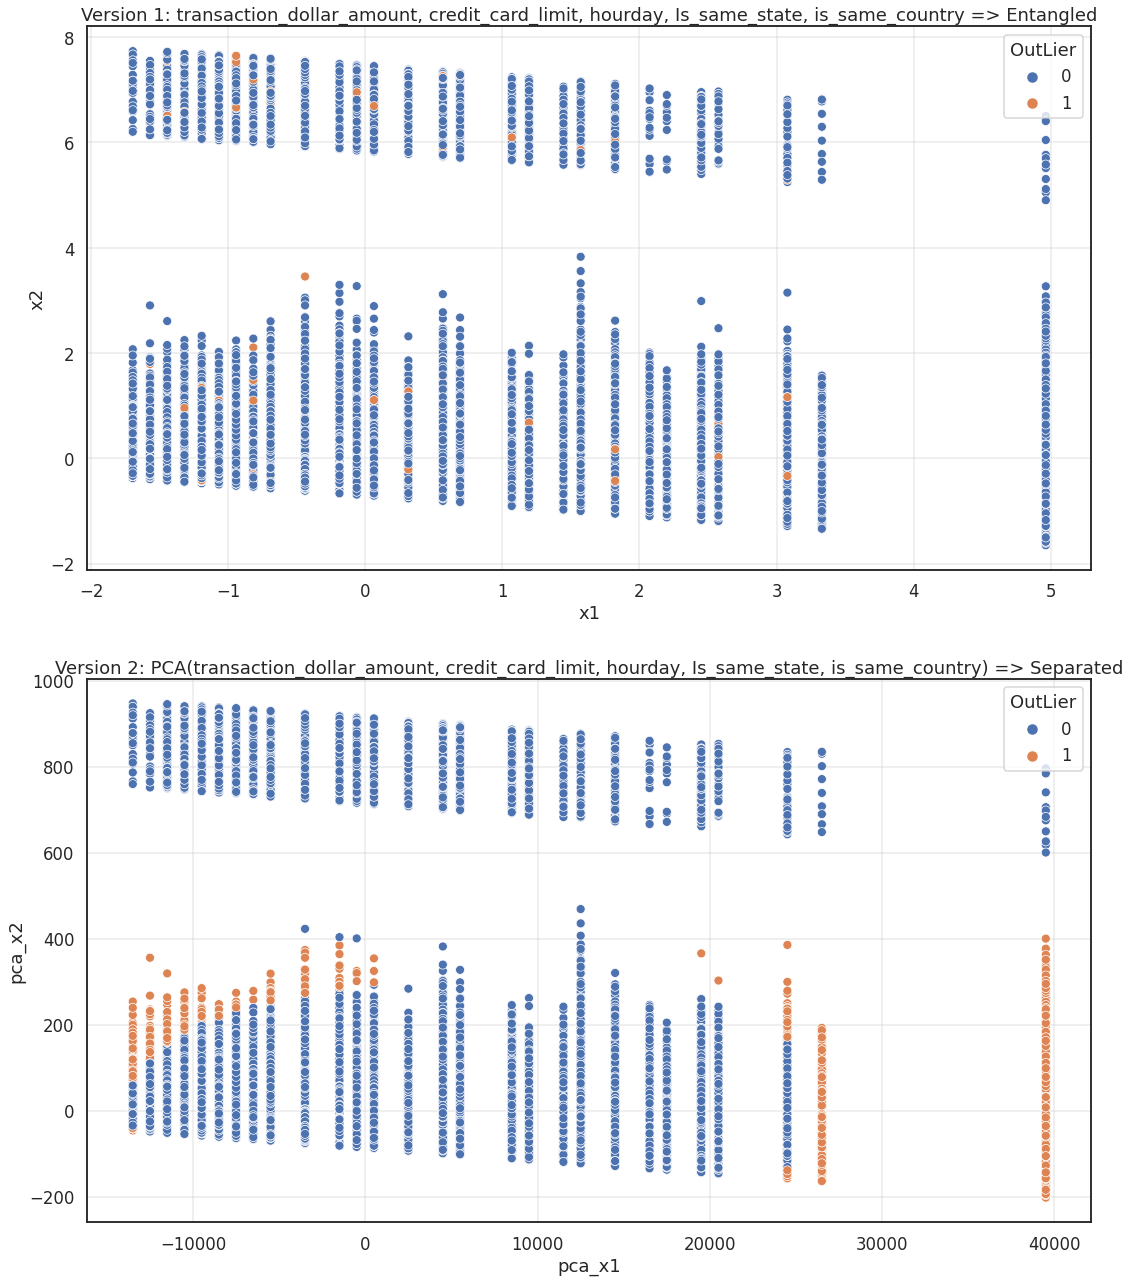

In [24]:
# Viz
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 22))

sns.scatterplot(x="x1", y="x2", hue='OutLier', ax = ax[0], data=pca_res1)
sns.scatterplot(x="pca_x1", y="pca_x2", hue='OutLier', ax = ax[1], data=res2)

ax[0].set_title("Version 1: transaction_dollar_amount, credit_card_limit, hourday, Is_same_state, is_same_country => Entangled",fontsize = 18)
ax[0].grid("--",alpha = 0.4)
ax[1].set_title("Version 2: PCA(transaction_dollar_amount, credit_card_limit, hourday, Is_same_state, is_same_country) => Separated",fontsize = 18)
ax[1].grid("--",alpha = 0.4)

plt.show()

### 3-3. Validations
The outliers/anomalies are supposed to have a lower than average mean of "is_same_state" and "is_same_country"

**For Version 1:**

In [32]:
res1[res1.OutLier ==1].describe()

,transaction_dollar_amount,credit_card_limit,is_same_state,is_same_country,hourday_afternoon,hourday_midnight,hourday_morning,hourday_night,Label,Dist,OutLier
count,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.0
mean,359.085655,16048.749470,0.453582,0.470962,0.402077,0.407800,0.169775,0.020348,1.211954,132.852042,1.0
std,400.925077,7691.017252,0.497893,0.499209,0.490369,0.491478,0.375475,0.141201,0.739859,109.397985,0.0
min,0.070000,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.858314,1.0
25%,48.315000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,82.454845,1.0
50%,103.965000,15000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,85.495603,1.0
75%,874.370000,20000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,87.728540,1.0
max,999.970000,55000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,439.517598,1.0


**For Version 2:**

In [28]:
res2[res2.OutLier ==1].describe()

,pca_x1,pca_x2,Label,Dist,OutLier
count,1973.000000,1973.000000,1973.000000,1973.000000,1973.0
mean,19910.176737,27.474045,1.458692,21.116581,1.0
std,20223.225630,125.019056,0.888820,11.789299,0.0
min,-13502.248617,-202.160627,0.000000,5.583232,1.0
25%,-5501.262726,-65.432898,0.000000,7.279286,1.0
50%,26497.912752,10.448461,2.000000,19.204497,1.0
75%,39497.858226,117.740392,2.000000,35.969874,1.0
max,39499.297823,400.046766,2.000000,45.742572,1.0



# Appendix
---



In [30]:
X3 = new_data[["is_same_state","is_same_country"]]
km3 = KMeans(n_clusters = 2, init='k-means++', n_init = 10, max_iter=100, random_state=123, n_jobs=-1)
km3 = km3.fit(X3)
km3_label = km3.predict(X3)

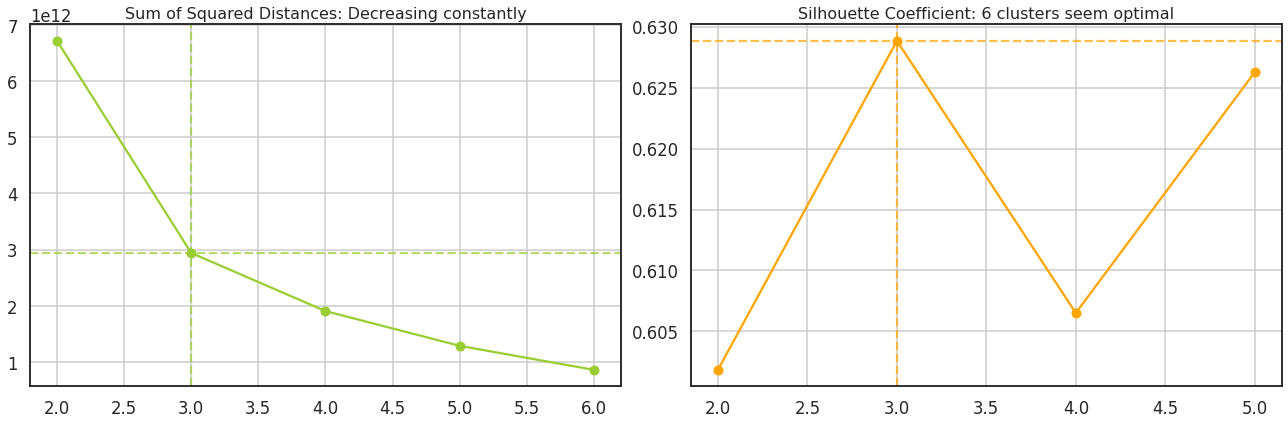

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

# determine the best number of clusters
# Please replace the X as the actual data in use
# clusters = range(2, 6)
# inertias = []
# silhouettes = []

# for n_clusters in clusters:
#     print(f"Building K-Means(K={n_clusters})...")
#   # Set n_init=10 to run k-means clustering algorithm 10 times independently
#   # with different centroids to choose the final model with the lowest SSE
#     kmeans = KMeans(n_clusters = n_clusters, init='k-means++', n_init = 10, max_iter=50, random_state=123, n_jobs=-1)
#     kmeans = kmeans.fit(X)
#     label = kmeans.predict(X)
    
#     inertias.append(kmeans.inertia_)
#     silhouettes.append(silhouette_score(X, label))
    
# visualization
clusters = range(2,7)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(range(2,7), inertias, 'o-',color = "yellowgreen")
ax[0].set_title("Sum of Squared Distances: Decreasing constantly",fontsize = 16)
ax[0].axhline(y=inertias[1],ls="--",c="yellowgreen",alpha = 0.7)
ax[0].axvline(x=3,ls="--",c="yellowgreen",alpha = 0.7)
ax[0].grid(True)

ax[1].plot(range(2,6), silhouettes, 'o-',color = "orange")
ax[1].grid(True)
ax[1].axhline(y=silhouettes[1],ls="--",c="orange",alpha = 0.7)
ax[1].axvline(x=3,ls="--",c="orange",alpha = 0.7)
ax[1].set_title("Silhouette Coefficient: 6 clusters seem optimal",fontsize = 16)
plt.tight_layout()
plt.show()